In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap

from tqdm import tqdm

In this notebook we will work with already chosen district. On the example of Nagorny distrtict you will study commercial diversity and chruchevki.

### Load the district polygon

In [3]:
district = gpd.read_file('Akademicheskij/Akademicheskij_district.geojson')

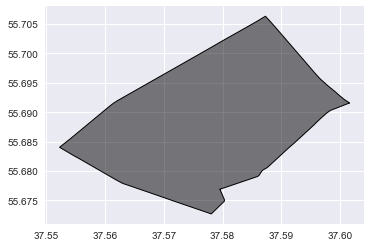

In [4]:
district.plot()

### Load google places:

In [5]:
google_places = gpd.read_file('Akademicheskij/Akademicheskij_google_places.geojson')

So we have 3757 places located in Nagornyj district. 

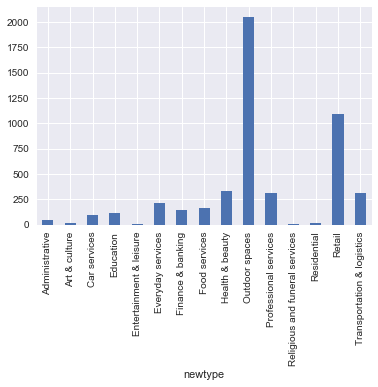

In [6]:
google_places.groupby('newtype', sort=True).size().plot(kind='bar')

We see that Outdoor spaces and Retail are the most popular venues.

In [7]:
google_places.newtype.value_counts()

Outdoor spaces                    2045
Retail                            1093
Health & beauty                    326
Transportation & logistics         314
Professional services              309
Everyday services                  212
Food services                      159
Finance & banking                  142
Education                          109
Car services                        95
Administrative                      46
Residential                         15
Art & culture                       13
Religious and funeral services       6
Entertainment & leisure              5
Name: newtype, dtype: int64

### Load houses

In [8]:
houses = gpd.read_file('Akademicheskij/Akademicheskij_chruchevki.geogson')

In [9]:
houses.shape

(162, 22)

### Interactive maps with Folium

To create a base map, simply pass starting coordinates to Folium, then create the map. The starting coordinates are the **center of district polygon**:

In [10]:
center_lat = list(district.centroid[0].coords)[0][1]
center_lon = list(district.centroid[0].coords)[0][0]

In [11]:
map_places = folium.Map([center_lat, center_lon], tiles='cartodb positron', zoom_start=14,control_scale=True)
map_places

Folium also supports two zoom parameters:

zoom_start: The starting zoom level.

max_zoom: The maximum possible zoom.

#### Tilesets

Folium natively supports five tilesets with no API key or custom URL required. You can pass any of the following strings to the tiles keyword:

‘OpenStreetMap’

‘Mapbox Bright’ (Limited levels of zoom)

‘Mapbox Control Room’ (Limited levels of zoom)

‘Stamen Terrain’

‘Stamen Toner’

### Data Mapping: GeoJSON 

Folium allows you to plot a GeoJSON overlay on the map. There is no requirement to bind data (passing just a GeoJSON will plot a single color overlay), but there is a data binding option to map Python Pandas columnar data to different feature objects on a color scale. Folium allows you to pass multiple GeoJSON datasets if you desire to create multiple overlays on a single map.


In [12]:
map_places = folium.Map([center_lat, center_lon], tiles='cartodb positron', zoom_start=14,control_scale=True)

#Define style for geojson objects
style_function = lambda feature: dict(fillColor='#AECCAE',
                                      color='#AECCAE',
                                      weight=1,
                                      opacity=0.3)

points = folium.features.GeoJson(houses,name='Khurshevki houses')
polygon = folium.features.GeoJson(district, style_function=style_function,name='district boundary')

#adding points to the map
map_places.add_child(points,name='Khurshevki houses')
map_places.add_child(polygon,name='district boundary')

#Switch between layers
folium.LayerControl().add_to(map_places)
map_places

### Heatmaps

Heatmaps are a great GIS tool to show the geographic clustering of a phenomenon. We can 
show the overall "concentration" as a heat map that adjusts as you zoom in or out? Folium gives us a good solution.

In [13]:
transport = google_places[google_places['newtype'] == 'Transportation & logistics']
retail = google_places[google_places['newtype'] == 'Retail']

transport_coords = list(zip(transport.lat, transport.lon))
retail_coords = list(zip(retail.lat, retail.lon))

In [14]:
map_places = folium.Map([center_lat, center_lon], tiles='cartodb positron', zoom_start=14,control_scale=True)


colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  1.0: 'red'}


HeatMap(transport_coords,
        name='transport',
        radius=10, 
        min_opacity=0.8,
       gradient={0.0: 'pink', 0.3: 'blue', 0.5: 'green',  1.0: 'red'}).add_to(map_places)

HeatMap(retail_coords,
        name='retail',
        radius=13, 
        min_opacity=0.8,
       gradient={.0: 'white', .2: '#E0EEE0', .4: '#C1CDC1', .6: '#838B83', .8:'#C1FFC1', 1.:'#698B69'}).add_to(map_places)



colormap = folium.LinearColormap(colors = colormap.values())
colormap.caption = 'Density of places'
map_places.add_child(colormap)


#Switch between layers
folium.LayerControl().add_to(map_places)
map_places

There's your heat map. Can you see concentrations? Pan around, zoom in, and out. Do we have specific areas with higher concentrations of google places?

#### Total code for map

Folium allows to create different layers and we can create heatmaps for each venue category.

In [15]:
map_places = folium.Map([center_lat, center_lon], tiles='cartodb positron', zoom_start=14,control_scale=True)

#Define style for geojson objects
style_function = lambda feature: dict(fillColor='AECCAE',
                                      color='#DCDCDC',
                                      weight=.01,
                                      opacity=0.01)

points = folium.features.GeoJson(houses,name='Khurshevki houses')
polygon = folium.features.GeoJson(district, style_function=style_function,name='district boundary')

colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  1.0: '#DEFFDE'}
#colormap = {.0: 'white', .2: '#E0EEE0', .4: '#C1CDC1', .6: '#838B83', .8:'#C1FFC1', 1.:'#698B69'}


for category, group in google_places.groupby('newtype'):
    
    coords = list(zip(group.lat, group.lon))
    
    HeatMap(coords,
            name=category,
            radius=13, 
            min_opacity=0.8,
           gradient=colormap).add_to(map_places)


colormap = folium.LinearColormap(colors = colormap.values())
colormap.caption = 'Density of places'
map_places.add_child(colormap)

#adding points to the map
map_places.add_child(points,name='Khurshevki houses')
map_places.add_child(polygon,name='district boundary')

#Switch between layers
folium.LayerControl().add_to(map_places)
map_places

To save the map as html page

In [16]:
map_places.save('akadem.html')

Additional folium examples are available here: [folium documentation](http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/)